In [57]:
import jax.numpy as np
from jax import jit
from discopy import Tensor
Tensor.np = np

import discopy

## Corpus Generation

In [7]:
from discopy import Diagram, Id, Cup, Ty, Word
from sklearn.model_selection import train_test_split

# Define our variables via discopy
s, n = Ty('s'), Ty('n') # Grammer types
Alice, Bob, Eve = Word('Alice', n), Word('Bob', n), Word('Eve', n)
loves, hates, kills =  Word('loves', n.r @ s @ n.l),  Word('hates', n.r @ s @ n.l) , Word('kills', n.r @ s @ n.l)

# Establish our grammar
grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

# Generate our dataset
sentences=[]
parsing = {"{} {} {}".format(subj, verb, obj): subj @ verb @ obj >> grammar
            for subj in [Alice, Bob, Eve] for verb in [loves, hates, kills] for obj in [Alice, Bob, Eve]}

for phrase in parsing:
    sentences.append(phrase)
    
# Let's split our data into training, dev, and test set
train_sentences, test_sentences = train_test_split(sentences, test_size=0.5, random_state=42)
test_sentences, dev_sentences= train_test_split(test_sentences, test_size=0.5, random_state=42)

# Print our datasets 
print("Training set:\n{}\n".format('\n'.join(train_sentences)))
print("Testing set:\n{}\n".format('\n'.join(map(str, test_sentences))))
print("Dev set:\n{}".format('\n'.join(map(str, dev_sentences))))

Training set:
Bob kills Alice
Eve hates Bob
Alice hates Alice
Eve kills Bob
Eve hates Eve
Eve loves Alice
Eve kills Eve
Eve loves Eve
Alice kills Bob
Bob loves Bob
Bob hates Eve
Eve loves Bob
Alice kills Alice

Testing set:
Bob hates Bob
Alice loves Eve
Alice loves Alice
Bob kills Eve
Alice loves Bob
Eve hates Alice
Bob kills Bob

Dev set:
Eve kills Alice
Alice hates Bob
Alice kills Eve
Alice hates Eve
Bob loves Eve
Bob hates Alice
Bob loves Alice


In [8]:
# Assignate true(1) and false(0) labels to our data (random)
train_labels = [1, 1, 1, 1, 1, 1,0,0,0,0,0,0,0]
dev_labels = [1,1,1,0,0,0,0]
test_labels = [0,0,0,1,1,1,1]

train_labels = np.array(train_labels)
dev_labels = np.array(dev_labels)
test_labels = np.array(test_labels)

# Sentences into diagrams

In [26]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

# Suggestion: print out some of your DisCoCat diagrams using
# `grammar.draw` to check that they make sense.

# TODO implement sentence2diagram
tv = n.r @ s @ n.l

def sentence2diagram(s):
    for subj, verb, obj in [s.split(' ')]:
        diagram = Word(subj, n) @ Word(verb, tv) @ Word(obj, n) >> grammar
    return diagram

train_diagrams = [sentence2diagram(s) for s in train_sentences]
dev_diagrams = [sentence2diagram(s) for s in dev_sentences]
test_diagrams = [sentence2diagram(s) for s in test_sentences]


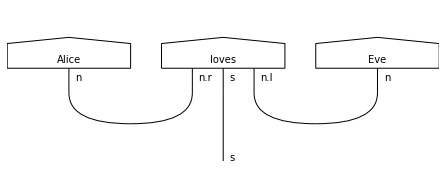

In [25]:
#from sympy.abc import phi
from discopy.grammar import draw
draw(test_diagrams[1], draw_type_labels=True)

# Diagrams into circuits

In [27]:
from discopy.quantum import Ket, H, Rx, CX, sqrt

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ sqrt(2) @ Rx(phase) >> CX

print(verb_ansatz(0).eval())


Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0.99999994+0.j, 0.    +0.j, 0.    +0.j, 0.99999994+0.j])


Circuit for 'train_sentences[0]': Bob kills Alice


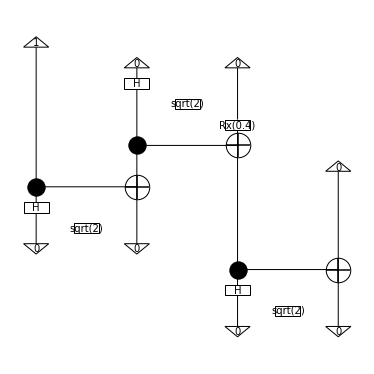

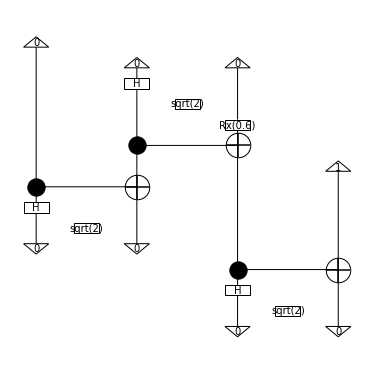

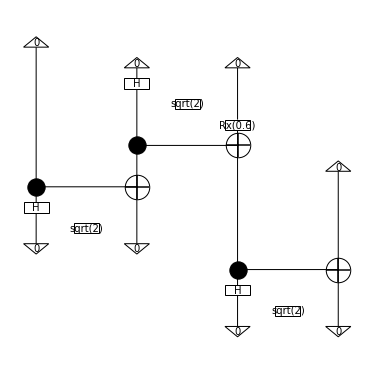

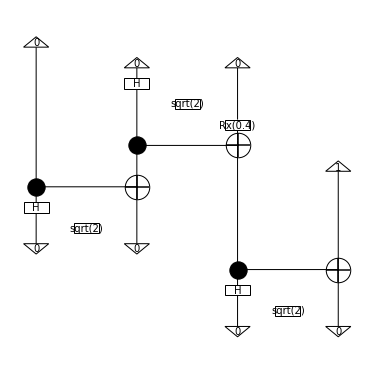

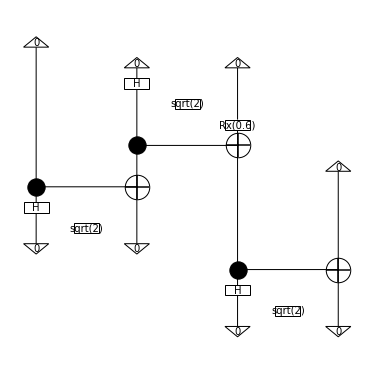

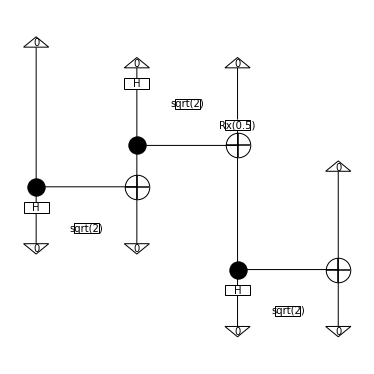

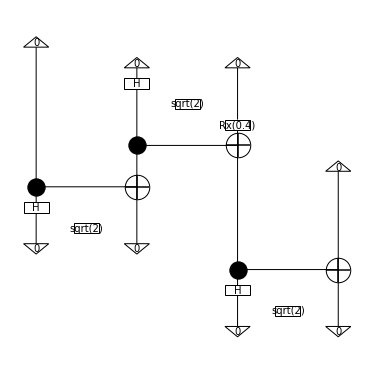

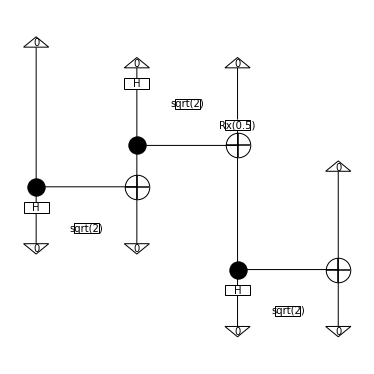

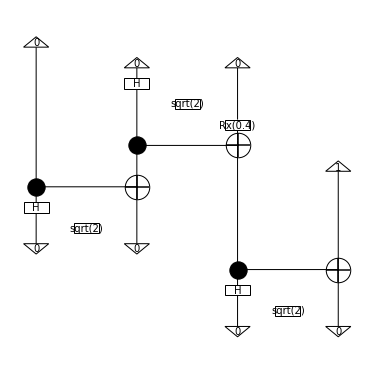

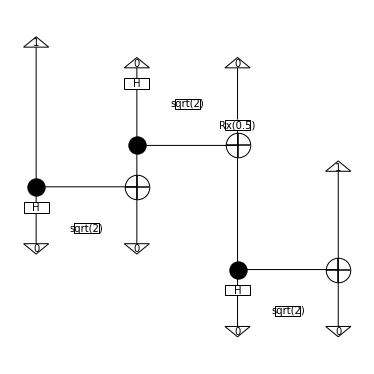

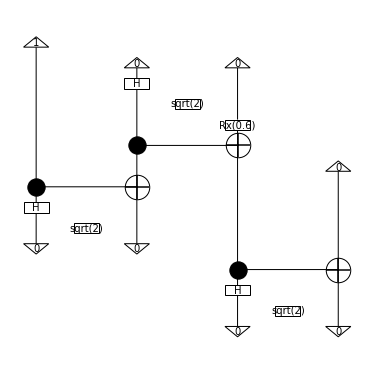

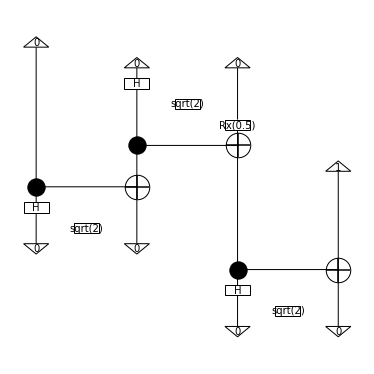

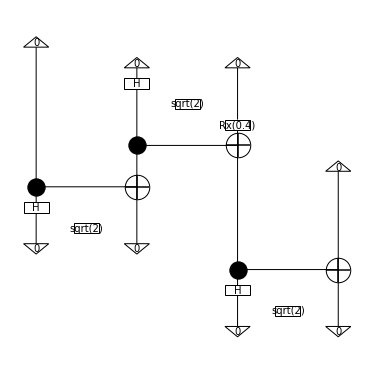

In [29]:
from discopy import CircuitFunctor, qubit

ob = {s: Ty(), n: 1}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1), Eve: Ket(0),
    kills: verb_ansatz(params['kills']),
    loves: verb_ansatz(params['loves']),
    hates: verb_ansatz(params['hates'])}

F = lambda params: CircuitFunctor(ob, ar(params))

params={'kills':0.4,'loves':0.5, 'hates':0.6}

print("Circuit for 'train_sentences[0]':", train_sentences[0])

for i in train_sentences:
    F(params)(parsing[i]).draw(
        aspect='auto', draw_type_labels=False, figsize=(5, 5))